# A. Reproducibility & readability

In [646]:
"""
The code needs to be run in sequence.
Some functions could be used later.
"""
import numpy as np
np.random.seed(61116)

import torch
torch.manual_seed(61116)

import random
random.seed(61116)

# B. Logistic Regression on BreastMNIST

## B.1 Data loading and inspection

In [356]:
# Import necessary packages
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator

In [4]:
# Using code from getting_started.ipynb in github MedMNIST repository
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.1

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# With some changes
train_dataset = DataClass(split='train')
val_dataset = DataClass(split='val')
test_dataset = DataClass(split='test')

In [360]:
"""Image Dispaly functions.
Process:
    Get specific number of pictures from each class.
    Dispaly the pictures in a row.
"""

# Get image batches
def get_sample(dataset, class_index, sample_num):
    sample = []
    for each_class in class_index:
        num = 0
        point = 0
        while (num < sample_num) & (point < len(dataset)):
            img, target = dataset.__getitem__(point)
            point+=1
            if target==each_class:
                sample.append([img, target])
                num+=1
    return sample

# Display all the sampled pics
def display_sample(sample, class_dict, sample_num, display_title):
    class_num = len(class_dict)
    for i in range(class_num):
        fig = plt.figure(figsize=[10, 1.5])
        plt.title(display_title + class_dict[str(i)])
        for j in range(sample_num):
            img = sample[i*sample_num+j][0]
            fig.add_subplot(1, 10, j+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.show()

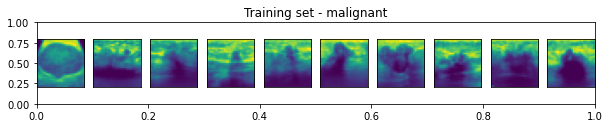

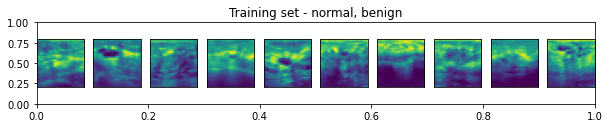

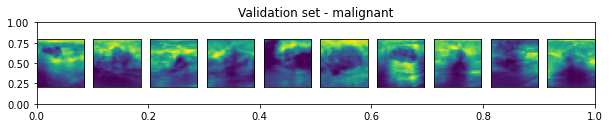

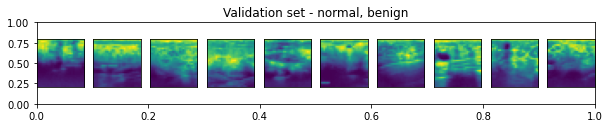

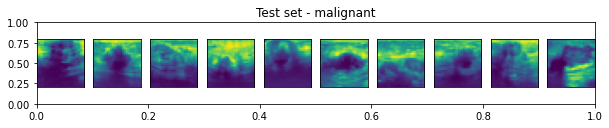

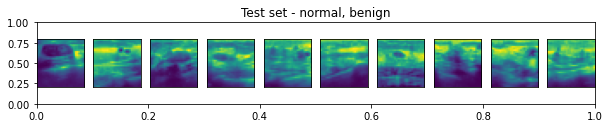

In [18]:
"""Prepare class index and dictionary,
   which can be fetched by print(dataset).
For example: 
    ->print(train_dataset)
    ->Dataset BreastMNIST (breastmnist)
        Number of datapoints: 546
        Root location: ...
        Split: train
        Task: binary-class
        Number of channels: 1
        Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
        Number of samples: {'train': 546, 'val': 78, 'test': 156}
        Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images...
"""
class_index = [0, 1]
class_dict = {'0': 'malignant', '1': 'normal, benign'}

# Process three datasets
train_sample = get_sample(train_dataset, class_index, 10)
display_sample(train_sample, class_dict, 10, "Training set - ")

val_sample = get_sample(val_dataset, class_index, 10)
display_sample(val_sample, class_dict, 10, "Validation set - ")

test_sample = get_sample(test_dataset, class_index, 10)
display_sample(test_sample, class_dict, 10, "Test set - ")

## B.2 Logistic regression

### B.2.a scikit-learn

In [19]:
from sklearn.model_selection import GridSearchCV
"""
Load the dataset in the way of pytorch.
"""
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
trainval_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

Using downloaded and verified file: C:\Users\fzkuji\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\fzkuji\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\fzkuji\.medmnist\breastmnist.npz


In [20]:
"""
The torch.dataset cannot be used by sklearn.
Therefore, write a function to transform.
"""

def dataset_torch2sklearn(dataset):
    """
    The function to transform data type from torch.dataset to numpy.
    where,
        X: images
        y: labels
    Args:
        dataset: torch.dataset
    """
    X = []
    y = []
    feature_size = torch.flatten(dataset[0][0]).shape
    
    for feature, label in dataset:
        X.append(np.array(feature))
        y.append(np.array(label))

    X = np.array(X).reshape(len(dataset), feature_size[0])
    y = np.array(y).ravel()
    return X, y

# Transfer processing
XTrain, yTrain = dataset_torch2sklearn(train_dataset)
XVal, yVal = dataset_torch2sklearn(val_dataset)
XTest, yTest = dataset_torch2sklearn(test_dataset)
XTrainval, yTrainval = dataset_torch2sklearn(trainval_dataset)

In [21]:
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

"""Cross-validation Preparation.
Process:
    Prepare whole training data.
    Set PredefinedSplit.
"""

# Set PredefinedSplit
test_fold = np.zeros((np.shape(XTrainval)[0], 1))
test_fold[0:np.shape(XTrain)[0]] = -1
ps = PredefinedSplit(test_fold)

"""Parameters Preparation.
Process:
    Set each parameter(n_estimators, max_features and max_samples).
    Create gird.
"""
# Prepare parameters for search
C = [1, 10, 100, 1000]
print("C:", C)

# Create gird
param_grid = {
    'C': C,
}

"""Grid Search Training.
Process:
    Grid Search for best parameters.
    Output the best values.
"""
# Grid Search
grid_regression = GridSearchCV(LogisticRegression(max_iter=5000), param_grid=param_grid, cv=ps, verbose=10)
grid_regression.fit(XTrainval, yTrainval)

# Print the best values
print(grid_regression.best_score_,grid_regression.best_params_)

C: [1, 10, 100, 1000]
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1; 1/4] START C=1.........................................................
[CV 1/1; 1/4] END ..........................C=1;, score=0.846 total time=   0.0s
[CV 1/1; 2/4] START C=10........................................................
[CV 1/1; 2/4] END .........................C=10;, score=0.859 total time=   0.0s
[CV 1/1; 3/4] START C=100.......................................................
[CV 1/1; 3/4] END ........................C=100;, score=0.872 total time=   0.0s
[CV 1/1; 4/4] START C=1000......................................................
[CV 1/1; 4/4] END .......................C=1000;, score=0.872 total time=   0.1s
0.8717948717948718 {'C': 100}


In [22]:
from sklearn.metrics import accuracy_score

"""Final Training."""
# Training with best parameters
clf = LogisticRegression(solver='sag', max_iter=5000, C=100).fit(XTrain, yTrain)

# Prediction
yTrain_pred = clf.predict(XTrain)
yVal_pred = clf.predict(XVal)
yTest_pred = clf.predict(XTest)
# Calculate accuracy with sklearn.metrics.accuracy_score
sklearn_Training_accuracy = accuracy_score(yTrain, yTrain_pred)
sklearn_Validation_accuracy = accuracy_score(yVal, yVal_pred)
sklearn_Testing_accuracy = accuracy_score(yTest, yTest_pred)

print("Training_accuracy:", sklearn_Training_accuracy)
print("Validation_accuracy:", sklearn_Validation_accuracy)
print("Testing_accuracy:", sklearn_Testing_accuracy)

Training_accuracy: 1.0
Validation_accuracy: 0.8717948717948718
Testing_accuracy: 0.7564102564102564


### B.2.b pytorch

In [23]:
# Encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

In [24]:
# create the logistic regression model
class LogisticRegression(torch.nn.Module):
    """
    Class to define a LogisticRegression model
    with sigmoid activation function.
    """
    def __init__(self):
        
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(784, 1)
        
    def forward(self, x):
            y_pred = torch.sigmoid(self.linear(x))
            return y_pred

In [25]:
#Trainging parameters
steps = 10000
l2_lambda = 0.001

# Prepare model
LR=LogisticRegression()
criterion = torch.nn.BCELoss()

In [28]:
# Training process
for i in range(steps):
    
    # Get validation data
    batch_val = next(iter(val_loader))
    batch_xval, batch_yval = batch_val[0].view(batch_val[0].size(0), -1), batch_val[1].to(torch.float32).view([len(batch_val[0])])
    
    for batch_idx, sample in enumerate(train_loader):
        # Get training batch
        batch_x, batch_y = sample[0], sample[1].to(torch.float32).view([len(sample[0])])
        batch_x = batch_x.view(batch_x.size(0), -1)
        # Reset gradients
        LR.zero_grad()

        # Forward pass
        l2_reg = torch.tensor(0.)
        for param in LR.parameters():
            l2_reg += torch.norm(param)
        output = criterion(torch.squeeze(LR(batch_x)), batch_y) + l2_reg*l2_lambda
        loss = output.item()

        # Backward pass
        output.backward()

        # Apply gradients
        for param in LR.parameters():
            param.data.add_(-0.05 * param.grad.data)

    if i % 1000 == 0:
        
        threshold = 0.5
        yVal_pred = LR(torch.tensor(XVal, dtype=torch.float32, requires_grad=True))
        
        yVal_pred[yVal_pred<=threshold] = 0
        yVal_pred[yVal_pred>threshold] = 1
        
        Validation_accuracy = accuracy_score(yVal, yVal_pred.detach().numpy())
        
        
        print('Training loss: {:.6f} '.format(loss, i), 'Validation accuracy: {:.6f}  after {} steps'.format(Validation_accuracy, i))

Training loss: 0.195120  Validation accuracy: 0.884615  after 0 steps
Training loss: 0.187764  Validation accuracy: 0.884615  after 1000 steps
Training loss: 0.181147  Validation accuracy: 0.884615  after 2000 steps
Training loss: 0.175155  Validation accuracy: 0.884615  after 3000 steps
Training loss: 0.169699  Validation accuracy: 0.884615  after 4000 steps
Training loss: 0.164706  Validation accuracy: 0.884615  after 5000 steps
Training loss: 0.160118  Validation accuracy: 0.884615  after 6000 steps
Training loss: 0.155885  Validation accuracy: 0.884615  after 7000 steps
Training loss: 0.151968  Validation accuracy: 0.884615  after 8000 steps
Training loss: 0.148331  Validation accuracy: 0.884615  after 9000 steps


In [29]:
# Same predict process
yTrain_pred = LR(torch.tensor(XTrain, dtype=torch.float32, requires_grad=True)).detach().numpy()
yVal_pred = LR(torch.tensor(XVal, dtype=torch.float32, requires_grad=True)).detach().numpy()
yTest_pred = LR(torch.tensor(XTest, dtype=torch.float32, requires_grad=True)).detach().numpy()

pytorch_Training_accuracy = accuracy_score(yTrain, (yTrain_pred>0.5)*1)
pytorch_Validation_accuracy = accuracy_score(yVal, (yVal_pred>0.5)*1)
pytorch_Testing_accuracy = accuracy_score(yTest, (yTest_pred>0.5)*1)

print("Training_accuracy:", pytorch_Training_accuracy)
print("Validation_accuracy:", pytorch_Validation_accuracy)
print("Testing_accuracy:", pytorch_Testing_accuracy)

Training_accuracy: 0.9761904761904762
Validation_accuracy: 0.8846153846153846
Testing_accuracy: 0.782051282051282


## B.3 Performance comparison

### B.2.a Summarise

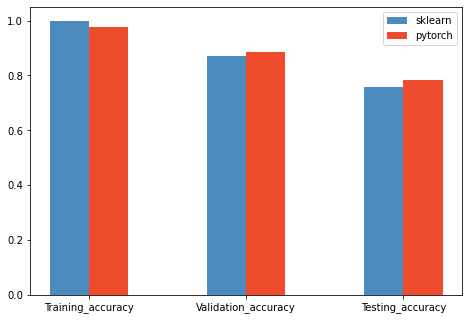

In [30]:
width = 0.25
# Obtain model performance
X = np.arange(3)
data = [[sklearn_Training_accuracy, sklearn_Validation_accuracy, sklearn_Testing_accuracy],
        [pytorch_Training_accuracy, pytorch_Validation_accuracy, pytorch_Testing_accuracy]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# Plot two kinds of bar in one chart

ax.bar(X + 0.00, data[0], color = '#4B8BBE', width = width) # 4B8BBE color of sklearn
ax.bar(X + width, data[1], color = '#EE4C2C', width = width)# EE4C2C color of pytorch
# Set labels of the x-axis
plt.xticks(X + width / 2, ('Training_accuracy', 'Validation_accuracy', 'Testing_accuracy'))
# Display legends
ax.legend(labels=['sklearn', 'pytorch'])

plt.show()

### B.2.a Observation

# C. Convolutional Neural Networks on OCTMNIST

In [357]:
# Using code from getting_started.ipynb in github MedMNIST repository
data_flag = 'octmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [358]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [36]:
train_dataset = DataClass(split='train')
print(train_dataset)

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: C:\Users\fzkuji\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


## C.1 Data loading and inspection

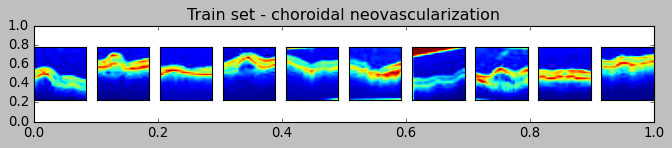

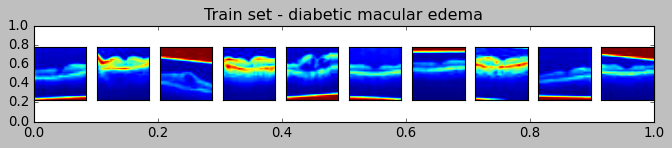

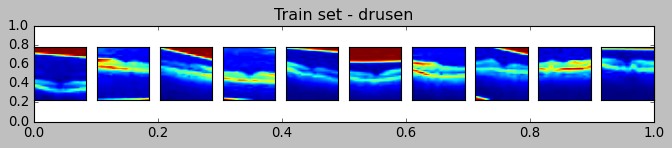

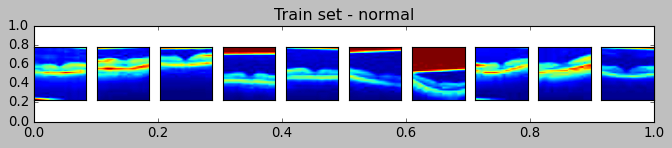

In [361]:
# load the data for dispaly
train_dataset = DataClass(split='train')
# Get and save the class of the dataset
class_index = [0, 1, 2, 3]
class_dict = {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
# Display sampled data
train_sample = get_sample(train_dataset, class_index, 10)
display_sample(train_sample, class_dict, 10, "Train set - ")
"""
Note:
    The plot could look different because of difference style of plt.style.
    The actual number is the same
"""

## C.2 Convolutional neural networks

In [40]:
# load the data for training
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\fzkuji\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\fzkuji\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\fzkuji\.medmnist\octmnist.npz


In [645]:
# define a simple CNN model

class Net(nn.Module):
    """Class to fit a define a 2-layer CNN model

    This version of model is only designed for demonstration.

    where,
        in_channels = the channel of a picture, 1 in this case;
        num_classes = the number of classes;
        x = the input batch.
    """
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 24 * 24, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Implementation of the 2-layer CNN model
model = Net(in_channels=n_channels, num_classes=n_classes)
    
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [646]:
# Define evaluation
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    if split == 'train':
        data_loader = train_loader_at_eval
    if split == 'val':
        data_loader = val_loader
    if split == 'test':
        data_loader = test_loader
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        
        print('%s  acc: %.3f  auc:%.3f' % (split, *metrics))

In [651]:
# Training process
for epoch in range(1):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 762/762 [01:27<00:00,  8.72it/s]


In [42]:
"""Output the result.
Note:
    The last result was cleared
    for a better readability.
"""
print(model)
print('==> Evaluating ...')
test('train')
test('val')
test('test')

### C.2.a Design a CNN with two Conv layers and two FC layers

#### Best 2-2 model

### C.2.b Design a CNN with three Conv layers and three FC layers

#### Best 3-3 model

## C.3 Performance comparison

### C.3.c Summarise

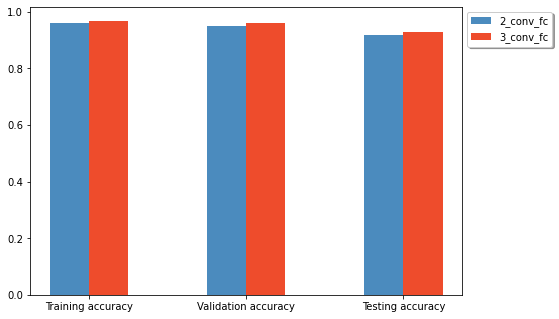

In [43]:
import matplotlib.pyplot as plt

width = 0.25

X = np.arange(3)
data = [[0.959, 0.949, 0.919],
        [0.969, 0.959, 0.929]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = '#4B8BBE', width = width)
ax.bar(X + width, data[1], color = '#EE4C2C', width = width)
plt.xticks(X + width / 2, ('Training accuracy', 'Validation accuracy', 'Testing accuracy'))
ax.legend(labels=['2_conv_fc', '3_conv_fc'], bbox_to_anchor=(1., 1.), fancybox=True, shadow=True)

plt.show()

### C.3.d Observation

# D. Unsupervised learning on Fashion-MNIST

## D.1 Dimensionality reduction and clustering

### D.1.a Visualise the top 5 eigenvectors

In [348]:
# Output plot directly
%matplotlib inline
# Importing required libraries
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

In [349]:
batchSize=128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

#Load the dataset
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

In [350]:
# Choosing two class from both train set and test set
# train set processing
idx = (trainset.targets==0) | (trainset.targets==1)
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
# test set processing
idx = (testset.targets==0) | (testset.targets==1)
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
# create dataloader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batchSize*2, shuffle=False, num_workers=2)

In [22]:
# Initialize PCA with first 5 principal components
pca = PCA(5)

# Applying PCA to dataset and inverse transform
trainset_transformed = pca.fit_transform(trainset.data.view(len(trainset), -1))
trainset_inverted = pca.inverse_transform(trainset_transformed)

Text(0.5, 0.98, '5-Component PCA')

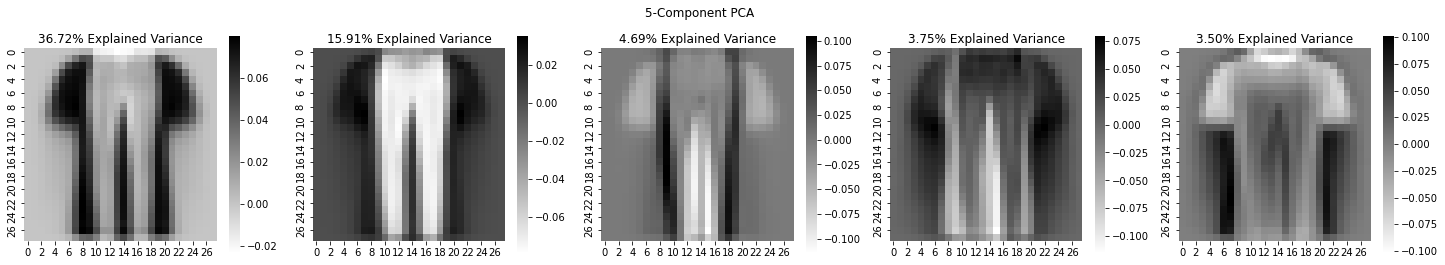

In [27]:
# Dispaly the top 5 eigenvectors
import seaborn as sns
import matplotlib.pyplot as plt

# Create five subplots
fig, axarr = plt.subplots(1, 5, figsize=(25, 4))
# Plot pictures
sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap='gray_r')
sns.heatmap(pca.components_[2, :].reshape(28, 28), ax=axarr[2], cmap='gray_r')
sns.heatmap(pca.components_[3, :].reshape(28, 28), ax=axarr[3], cmap='gray_r')
sns.heatmap(pca.components_[4, :].reshape(28, 28), ax=axarr[4], cmap='gray_r')
# Set titles
axarr[0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100), fontsize=12)
axarr[1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100), fontsize=12)
axarr[2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100), fontsize=12)
axarr[3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100), fontsize=12)
axarr[4].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[4]*100), fontsize=12)
# Set the aspect ratio of the axes scaling
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')
axarr[2].set_aspect('equal')
axarr[3].set_aspect('equal')
axarr[4].set_aspect('equal')

plt.suptitle('5-Component PCA')

### D.1.b Use top 30 PCs to reconstruct images

In [58]:
#initialize PCA with first 30 principal components
pca = PCA(30)

#Applying PCA to dataset and inverse transform.
trainset_transformed = pca.fit_transform(trainset.data.view(len(trainset), -1))
trainset_inverted = pca.inverse_transform(trainset_transformed)

In [55]:
# Choose 10 images from class 0
# via traverse and save to list_i
idx = (trainset.targets==0)
list_0 = []
for i in range(len(trainset)):
    if idx[i] == True:
        list_0.append(i)
# Choose 10 images from class 1
idx = (trainset.targets==1)
list_1 = []
for i in range(len(trainset)):
    if idx[i] == True:
        list_1.append(i)

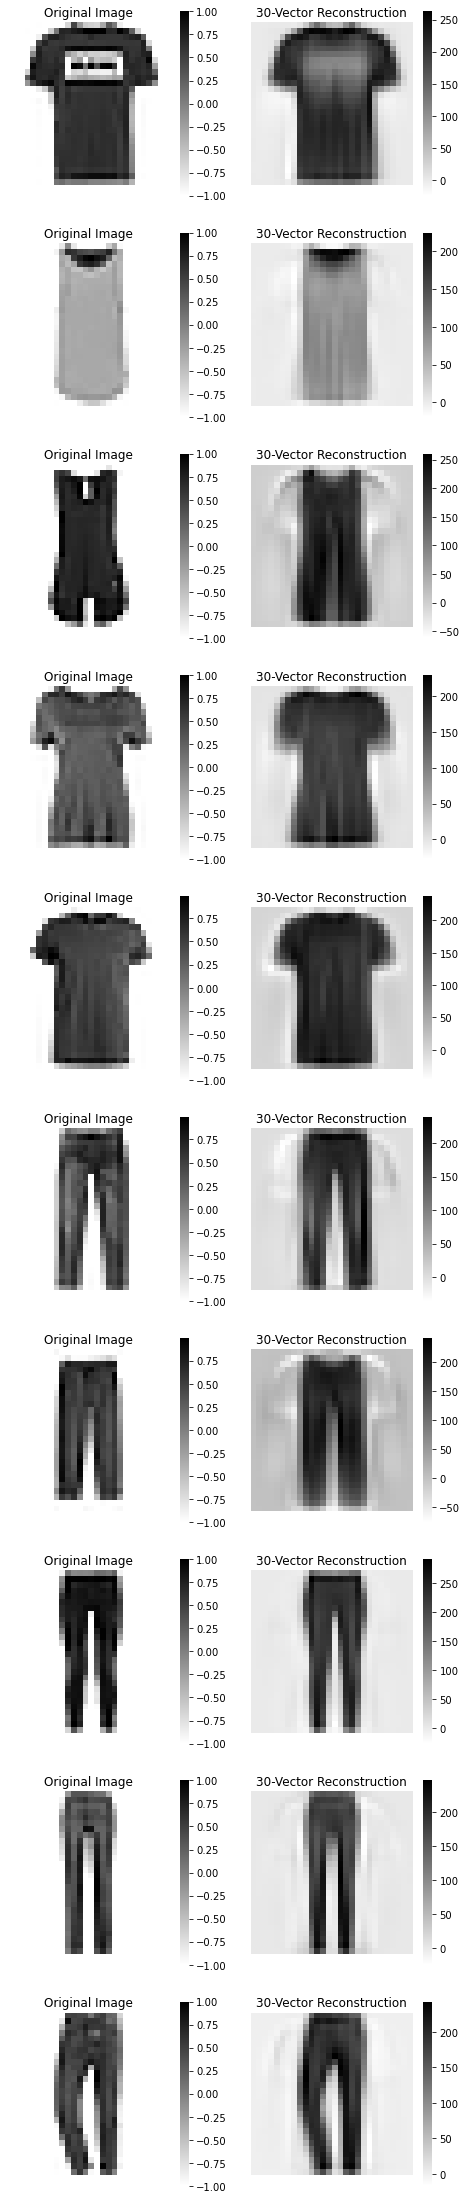

In [59]:
n_samples = 10

"""Display 5 pictures from each class.
Note:
    In this case, class 0 is T-shirt/top.
                  class 1 is Trouser.
"""
fig, axarr = plt.subplots(10, 2, figsize=(8, n_samples*4))
# Display class 0
for i in range(5):
    sns.heatmap(trainset[list_0[i]][0].reshape(28, 28), cmap='gray_r', ax=axarr[i, 0])
    sns.heatmap(trainset_inverted[list_0[i], :].reshape(28, 28), cmap='gray_r', ax=axarr[i, 1])
    axarr[i, 0].set_aspect('equal')
    axarr[i, 0].axis('off')
    axarr[i, 0].set_title("Original Image", fontsize=12)
    axarr[i, 1].set_aspect('equal')
    axarr[i, 1].axis('off')
    axarr[i, 1].set_title("30-Vector Reconstruction", fontsize=12)
# Display class 1
for i in range(5):
    sns.heatmap(trainset[list_1[i]][0].reshape(28, 28), cmap='gray_r', ax=axarr[i+5, 0])
    sns.heatmap(trainset_inverted[list_1[i], :].reshape(28, 28), cmap='gray_r', ax=axarr[i+5, 1])
    axarr[i+5, 0].set_aspect('equal')
    axarr[i+5, 0].axis('off')
    axarr[i+5, 0].set_title("Original Image", fontsize=12)
    axarr[i+5, 1].set_aspect('equal')
    axarr[i+5, 1].axis('off')
    axarr[i+5, 1].set_title("30-Vector Reconstruction", fontsize=12)

### D.1.c PCA Representations

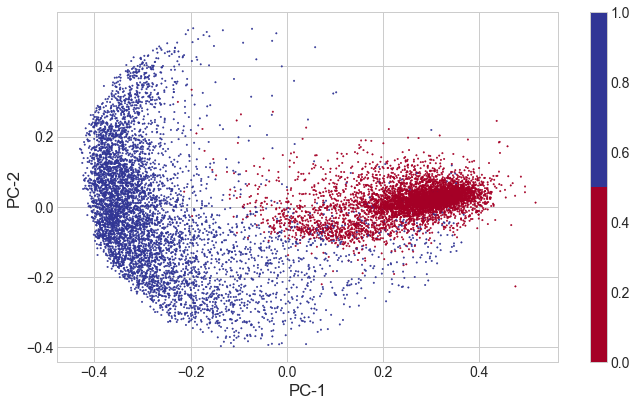

In [836]:
"""Visualisation of the two-dimensional PCA representations.
Args:
    trainset_norm_r: 30 principal components,
    trainset.targets: Sample labels,
    c_map: A Colormap instance or registered colormap name.
"""
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('RdYlBu', 2)
plt.scatter(trainset_norm_r[:, 0], trainset_norm_r[:, 1], s = 2, cmap = c_map, c = trainset.targets)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

### D.1.d Spectral clustering

In [136]:
from sklearn.cluster import SpectralClustering

"""Spectral clustering with SpectralClustering in sklearn.
Args:
    trainset_norm_r: 30 principal components,
    trainset.targets: Sample labels,
    c_map: A Colormap instance or registered colormap name.
"""
X = trainset_norm_r[:, 0:1]
clustering = SpectralClustering(n_clusters=2,
                                n_components=30,
                                affinity='rbf',
                                n_neighbors=3,
                                ).fit(X)
clustering

SpectralClustering(n_clusters=2, n_components=30, n_neighbors=3)

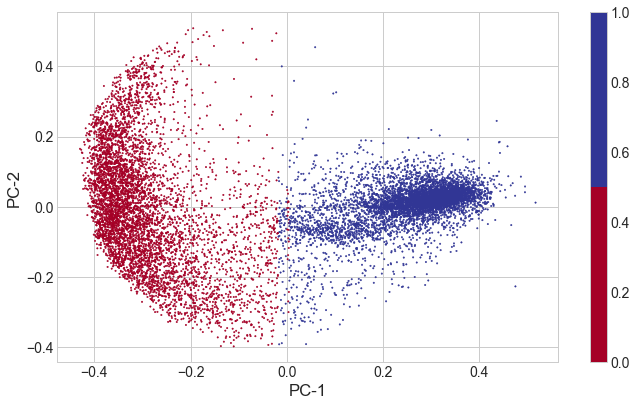

In [137]:
# Same as D.1.c
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('RdYlBu', 2)
plt.scatter(trainset_norm_r[:, 0], trainset_norm_r[:, 1], s = 2, cmap = c_map, c = clustering.labels_)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

### D.1.e Design an autoencoder

In [344]:
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

In [345]:
"""
Creates a Autoencoder with 5 encode/decode layer.
Using mish as activation function.
Turns out the simple 3x3 conv is the best.
"""
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=2)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=(3,3))
        self.conv5 = nn.Conv2d(32, 64, kernel_size=(3,3))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3))
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3))
        self.conv3 = nn.ConvTranspose2d(16, 8, kernel_size=(3,3), stride=2)
        self.conv4 = nn.ConvTranspose2d(8, 4, kernel_size=(3,3))
        self.conv5 = nn.ConvTranspose2d(4, 1, kernel_size=(3,3))
        self.sigmoid_activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.sigmoid_activation(x)
        return x

class Autoencoder(torch.nn.Module):
    """Class to fit a define an Autoencoder

    Both encoder and decoder have 5 3x3 convolution layers.
    Pooling makes the image lose too much information.
    """
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [352]:
model = Autoencoder()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.999)

# Loss function
loss_func = torch.nn.MSELoss()

epoches = 20
train_loss = []
for epoch in range(epoches):
    # Train
    model.train()
    for step, (images, _) in enumerate(train_loader):
        predict = model(images)
        loss = loss_func(images, predict)
        train_loss.append(loss.detach().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"{epoch}, training_loss {np.mean(train_loss)}", end=" ")
    
    # Validation
    model.eval()
    val_loss = []
    for step, (images, _) in enumerate(test_loader):
        predict = model(images.float())
        batch_loss = loss_func(images, predict)       
        val_loss.append(batch_loss.detach().cpu().numpy())
    print(f"validation_loss {np.mean(val_loss)}")
    scheduler.step()

0, training_loss 1.1377779828741195 validation_loss 0.7240310907363892
1, training_loss 0.9235973633984302 validation_loss 0.6993920803070068
2, training_loss 0.8491961121136415 validation_loss 0.6956579685211182
3, training_loss 0.8114475983571499 validation_loss 0.6943990588188171
4, training_loss 0.7886158104906691 validation_loss 0.6938014626502991
5, training_loss 0.7733213471394058 validation_loss 0.6935167908668518
6, training_loss 0.7623666394445309 validation_loss 0.693396806716919
7, training_loss 0.7541479735456883 validation_loss 0.6933419704437256
8, training_loss 0.7477464526539435 validation_loss 0.6933128833770752
9, training_loss 0.7426219930674167 validation_loss 0.6932956576347351
10, training_loss 0.7384286300933107 validation_loss 0.6932846307754517
11, training_loss 0.7349370954201576 validation_loss 0.6932772397994995
12, training_loss 0.7319826797358143 validation_loss 0.6932721138000488
13, training_loss 0.7294446157014116 validation_loss 0.6932684183120728
14,

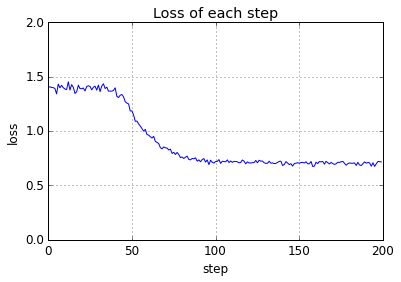

In [353]:
"""Plot the loss against the epoch->step
Note:
    Due to the fast learning rate,
    I have to plot the loss of each step
    instead of each epoch.
    Otherwise, there will be no difference 
    in the loss.
"""

plt.clf()
plt.style.use("classic")
# set title and axis name
plt.title("Loss of each step")
plt.xlabel("step")
plt.ylabel("loss")
# set grid range
plt.xlim((0, 200))
plt.ylim((0, 2))

plt.plot(train_loss[0:200])
plt.grid(visible=True)
plt.show()

## D.2 Observation